# Gas Storage Valuation using a Multi-Factor Least Squares Monte Carlo model

## Imports


In [260]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
from cmdty_storage import CmdtyStorage, three_factor_seasonal_value, SimulationDataReturned,\
value_from_sims

In [305]:
is_save_plots = input("Would you like to save the plots generated? Y/N")
if is_save_plots == 'Y':
    %matplotlib qt  
    print("Interactive plot mode enabled.")
elif is_save_plots == 'N':
    %matplotlib inline
    print("Inline plot mode enabled.")
else:
    print("Invalid input. Defaulting to inline plots.")
    %matplotlib inline

Would you like to save the plots generated? Y/NY
Interactive plot mode enabled.


## Data Load


In [262]:
CSV_FILE = "Storage parameters.csv"

In [263]:
param_data_df = pd.read_csv(CSV_FILE)

In [164]:
param_data_df

,Month,Price
0,Apr-24,28.30
1,May-24,28.40
2,Jun-24,28.50
3,Jul-24,28.60
4,Aug-24,28.95
5,Sep-24,29.50
6,Oct-24,30.50
7,Nov-24,33.20
8,Dec-24,34.40
9,Jan-25,34.60


In [264]:
price_data = param_data_df[param_data_df['Price'].notna() & param_data_df['Month'].str.contains('-', na=False)]

# Clean up non-price data and extract parameters
parameters = param_data_df[param_data_df['Price'].notna() & ~param_data_df['Month'].str.contains('-', na=False)]

# Convert parameters into a dictionary for easy access
params_dict = parameters.set_index('Month')['Price'].to_dict()

# Display results
print("Price Data:")
print(price_data)
print("\nParameters:")
for key, value in params_dict.items():
    print(f"{key}: {value}")

Price Data:
     Month  Price
0   Apr-24  28.30
1   May-24  28.40
2   Jun-24  28.50
3   Jul-24  28.60
4   Aug-24  28.95
5   Sep-24  29.50
6   Oct-24  30.50
7   Nov-24  33.20
8   Dec-24  34.40
9   Jan-25  34.60
10  Feb-25  34.70
11  Mar-25  34.20
12  Apr-25  32.40
13  May-25  31.90
14  Jun-25  31.40
15  Jul-25  31.50
16  Aug-25  31.70
17  Sep-25  31.90
18  Oct-25  32.50
19  Nov-25  33.50
20  Dec-25  34.75
21  Jan-26  35.00
22  Feb-26  35.20
23  Mar-26  34.70

Parameters:
Max Withdrawal Rate: 50.0
Min Injection Rate: 30.0
Minimum Inventory: 700.0
Maximum Inventory: 4000.0
Current Inventory: 750.0
Injection Cost: 0.55
Withdrawal Cost: 1.4


In [265]:
params_dict

{'Max Withdrawal Rate': 50.0,
 'Min Injection Rate': 30.0,
 'Minimum Inventory': 700.0,
 'Maximum Inventory': 4000.0,
 'Current Inventory': 750.0,
 'Injection Cost': 0.55,
 'Withdrawal Cost': 1.4}

### Summary Statistics

In [266]:
summary_stats = price_data['Price'].describe()
print(summary_stats)

count    24.000000
mean     32.095833
std       2.392057
min      28.300000
25%      30.250000
50%      32.150000
75%      34.450000
max      35.200000
Name: Price, dtype: float64


## Forward Curve

### Initial plotting of prices

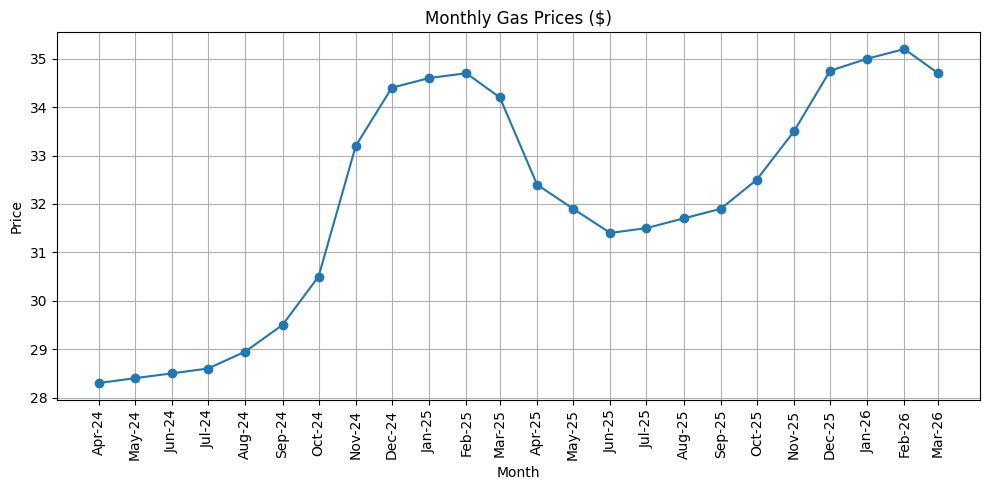

In [268]:
# Make a deep copy of the price dataframe for plotting purposes
price_data_df = price_data.copy(deep=True)

# Convert 'Month' to datetime format
price_data_df['Month'] = pd.to_datetime(price_data_df['Month'], format='%b-%y')

# Set 'Month' as the DataFrame index
price_data_df.set_index('Month', inplace=True)

# Plotting
plt.figure(figsize=(10,5))
plt.plot(price_data_df.index, price_data_df['Price'], marker='o')
plt.title('Monthly Gas Prices ($)')  # Title of the plot
plt.xlabel('Month')  # X-axis label
plt.ylabel('Price')  # Y-axis label

# Improve x-tick appearance
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=1))  # Set major ticks to show every month
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b-%y'))  # Format the date display
plt.xticks(price_data_df.index, rotation=90)  # Rotate x-axis labels for better readability

plt.grid(True)  # Turn the grid on
plt.tight_layout()  # Adjust layout to not cut off elements
plt.show()  # Display the plot

### Daily Granularity

Since we want to model the behaviour of the gas storage facility with daily granularity, we reconfigure our forward curve as stepwise function so that we have one price per month for all days of the month.  We have price 28.30 for all of the days within the month of April.  

In [10]:
list(price_data_df['Price'])

[28.3,
 28.4,
 28.5,
 28.6,
 28.95,
 29.5,
 30.5,
 33.2,
 34.4,
 34.6,
 34.7,
 34.2,
 32.4,
 31.9,
 31.4,
 31.5,
 31.7,
 31.9,
 32.5,
 33.5,
 34.75,
 35.0,
 35.2,
 34.7]

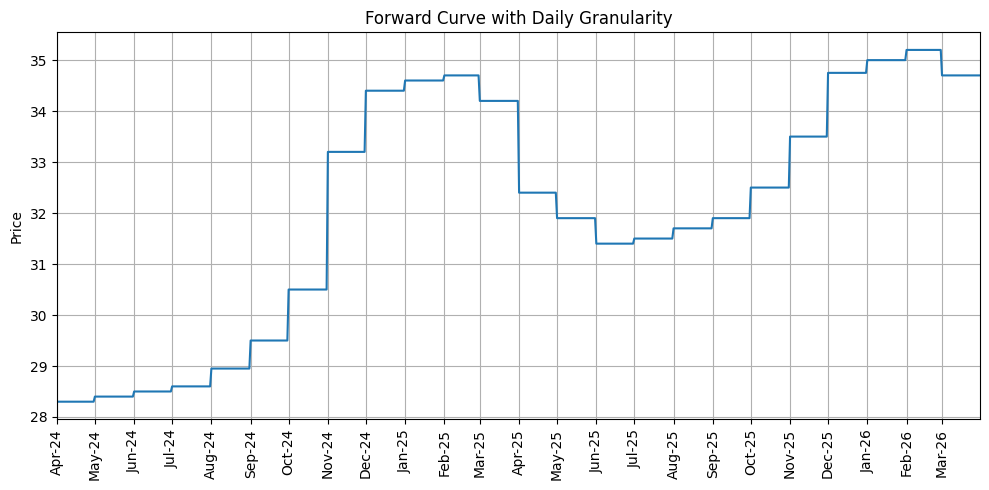

In [269]:
monthly_index = pd.period_range(start='2024-04-01', periods=24, freq='M')
fwd_curve = pd.Series(data = list(price_data_df['Price']), index=monthly_index).resample('D').fillna('pad')
plt.figure(figsize=(10,5))
fwd_curve.plot(title='Forward Curve with Daily Granularity')

plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=1))  # Set major ticks to show every month
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b-%y'))  # Format the date display
plt.xticks(rotation=90)
plt.ylabel('Price')  # Y-axis label

plt.grid(True)  # Turn the grid on
plt.tight_layout()  # Adjust layout to not cut off elements



# Modelling

## Creating Storage Instance

Note that given we have data for the forward curve from April 2024 to March 2026, we set 2026-03-30 to be the last possible day any action can be taken and thus the terminal storage npv is calculated on 2026-03-31. 

In [270]:
storage_simple = CmdtyStorage(
    freq = 'D',
    storage_start = '2024-04-01',
    storage_end = '2026-03-31',
    injection_cost = params_dict['Injection Cost'],
    withdrawal_cost = params_dict['Withdrawal Cost'],
    min_inventory = params_dict['Minimum Inventory'],
    max_inventory = params_dict['Maximum Inventory'],
    max_withdrawal_rate = params_dict["Max Withdrawal Rate"], 
    max_injection_rate = params_dict["Min Injection Rate"],
    terminal_storage_npv = lambda spot_price, inventory: 0.97 * spot_price * inventory
)

"""
Note in the above that from the param .csv file provided, we were given the min injection rate.
We have assumed that this was a typo and specified this as the max injection rate instead, as required
by the CmdtyStorage class.
""" 


'\nNote in the above that from the param .csv file provided, we were given the min injection rate.\nWe have assumed that this was a typo and specified this as the max injection rate instead, as required\nby the CmdtyStorage class.\n'

## Other Model Inputs

In [271]:
# Settlement Rule
def settlement_rule(delivery_date):
    return delivery_date.asfreq('M').asfreq('D', 'end') + 20

In [272]:
sim_data_returned = SimulationDataReturned.SPOT_VALUATION | SimulationDataReturned.FACTORS_REGRESS

### Interest Rate Curve

We use the latest treasury yield rates as of 7/05/2024 to construct an interpolated curve for use in the model

<Axes: title={'center': 'Interest Rate Curve'}>

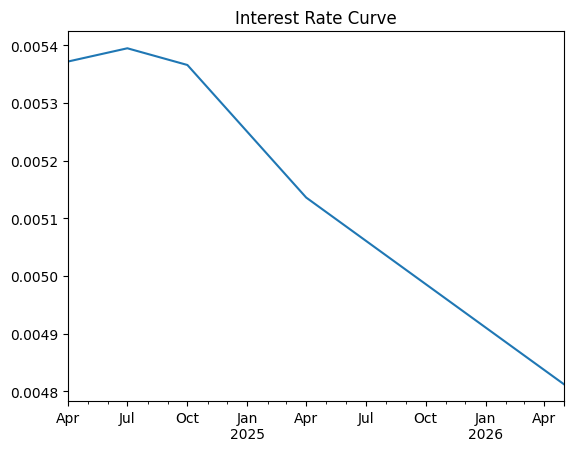

In [273]:
rates = [0.005372, 0.005395, 0.005366, 0.005136, 0.004812]
rates_pillars = pd.PeriodIndex(freq='D', data=['2024-04-01', '2024-07-01', '2024-10-01',
                                              '2025-04-01', '2026-05-01'])
ir_curve = pd.Series(data=rates, index=rates_pillars).resample('D').asfreq('D').interpolate(method='linear')
ir_curve.plot(title='Interest Rate Curve')

In [274]:
val_date = '2024-04-01'
inventory=750
discount_deltas = True

In [275]:
num_sims = 500
seed = 12
fwd_sim_seed = 25

## Calibration

### Three Factor Seasonal Commodity Price Process

In the below, we use the three-factor commodity price process developed by Jake C. Fowler.  The model requires 4 parameters, which can be drawn from historical data.  Since we do not have access to historical data, we instead use the data estimated from historical Dutch TTF prices in https://energyquants.com/assets/uploads/files/publications/boogert%20de%20jong%20gas%20storage%20multifactor.pdf

In [276]:
spot_mean_reversion = 12
spot_vol = 1
long_term_vol = 0.2
seasonal_vol = 0.2

### Basis Functions

We decided to use the same basis functiona as Fowler uses in the library docs.  These are verified to be good candidates in the literature.

In [178]:
three_factor_basis_functions = '1 + x_st + x_sw + x_lt + s + x_st**2 + x_sw**2 + x_lt**2 + s**2 + s * x_st'

## Calling the Three Factor Seasonal Model

In [93]:
three_factor_results = three_factor_seasonal_value(
    cmdty_storage = storage_simple,
    val_date = val_date,
    inventory = inventory,
    fwd_curve = fwd_curve,
    interest_rates = ir_curve,
    settlement_rule = settlement_rule,
    discount_deltas = discount_deltas,
    num_sims = num_sims,
    spot_mean_reversion = spot_mean_reversion,
    spot_vol = spot_vol,
    long_term_vol = long_term_vol,
    seasonal_vol = seasonal_vol,
    basis_funcs = three_factor_basis_functions,
    sim_data_returned = sim_data_returned,
    seed = seed,
    fwd_sim_seed = fwd_sim_seed,
)

In [95]:
print('Full NPV:\t{0:,.0f}'.format(three_factor_results.npv))
print('Intrinsic NPV: \t{0:,.0f}'.format(three_factor_results.intrinsic_npv))
print('Extrinsic NPV: \t{0:,.0f}'.format(three_factor_results.extrinsic_npv))

Full NPV:	19,473,308
Intrinsic NPV: 	44,350
Extrinsic NPV: 	19,428,958


In [304]:
display(three_factor_results.trigger_prices[0:10])

,inject_volume,inject_trigger_price,withdraw_volume,withdraw_trigger_price
2024-04-01,30.0,30.488489,-50.0,32.447845
2024-04-02,30.0,30.490031,-50.0,32.436616
2024-04-03,30.0,30.496226,-50.0,32.461713
2024-04-04,30.0,30.545165,-50.0,32.502136
2024-04-05,30.0,30.586765,-50.0,32.534110
2024-04-06,30.0,30.530595,-50.0,32.578326
2024-04-07,30.0,30.483813,-50.0,32.554417
2024-04-08,30.0,30.548451,-50.0,32.501800
2024-04-09,30.0,30.403197,-50.0,32.407518
2024-04-10,30.0,30.513787,-50.0,32.499198


In [233]:
three_sim_spot_valuation_mean = three_factor_results.sim_spot_valuation.aggregate(func='mean', axis='columns')
three_sim_spot_valuation_90th = three_factor_results.sim_spot_valuation.aggregate(func=np.percentile, q=90, axis='columns')
three_sim_spot_valuation_10h = three_factor_results.sim_spot_valuation.aggregate(func=np.percentile, q=10, axis='columns')

In [308]:
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(10, 15))

three_factor_results.trigger_prices['inject_trigger_price'].plot(ax=ax1, legend=True)
three_factor_results.trigger_prices['withdraw_trigger_price'].plot(ax=ax1, legend=True)
fwd_curve['2024-04-01' : '2026-04-01'].plot(ax=ax1, legend=True)
ax1.legend(['Inject Trigger Price', 'Withdraw Trigger', 'Forward Curve'])
ax1.set_title('Trigger Prices Versus Forward Curve')
ax1.grid(True)

three_factor_results.expected_profile['inventory'].plot(ax=ax2, legend=True, color='green')
ax2.set_title('Expected Inventory Profile')
ax2.grid(True)

three_sim_spot_valuation_mean.plot(ax=ax3, title='Statistics of Simulated Spot Prices', legend=True)
fwd_curve['2024-04-01' : '2026-04-01'].plot(ax=ax3, legend=True)
three_sim_spot_valuation_10h.plot(ax=ax3, legend=True)
ax3 = three_sim_spot_valuation_90th.plot(ax=ax3, legend=True)
ax3.legend(['Mean', 'Forward Curve', '10th Percentile', '90th Percentile'])
ax3.grid(True)

plt.tight_layout()
plt.show()

2024-05-09 21:47:58.367 python[50115:4697266] +[CATransaction synchronize] called within transaction
2024-05-09 21:48:06.233 python[50115:4697266] +[CATransaction synchronize] called within transaction
2024-05-09 21:48:07.323 python[50115:4697266] +[CATransaction synchronize] called within transaction
2024-05-09 21:48:07.589 python[50115:4697266] +[CATransaction synchronize] called within transaction


## One Factor Price Model

In [297]:
def generate_1f_sims(S0, k, mu, sigma, val_date, storage_end, num_sims, seed=None):
    
    # Set the seed for reproducibility
    if seed is not None:
        np.random.seed(seed)
    
    start_sim = pd.Period(val_date, freq='D')
    sim_periods = pd.period_range(start=start_sim, end=storage_end)
    num_sim_periods = len(sim_periods)
    sqrt_dt = np.sqrt(1/365.0)

    S = np.zeros((num_sim_periods, num_sims))
    S[0] = S0
    for i in range(1, num_sim_periods):
        Z = np.random.normal(loc=0.0, scale=1.0, size=num_sims)
        dt = 1/365.0  # assuming daily steps
        S[i] = S[i-1] * np.exp((k * (mu(sim_periods[i]) - np.log(S[i-1])) - 0.5 * sigma**2) * dt + sigma * sqrt_dt * Z)

    S_data_frame = pd.DataFrame(data=S, index=sim_periods)

    return S_data_frame

# Example usage:
# Define mu(t) as a function if it varies with time, or as a constant if it does not
def mu(t): 
    return np.log(fwd_curve[t])   # mean level as ln(100), modify as needed

In [298]:
sim_spot_regress = generate_1f_sims(fwd_curve[0], 12, mu, 0.2, val_date, '2026-03-31', 500, seed)
sim_spot_valuation = generate_1f_sims(fwd_curve[0], 12, mu, 0.2, val_date, '2026-03-31', 500, fwd_sim_seed)

In [292]:
## We use the same basis functions as in Boogert and de Jong
one_factor_basis_funcs = "1 + x0 + x0**2 + x0**3"

In [299]:
value_from_sims_results = value_from_sims(
    cmdty_storage = storage_simple,
    val_date = val_date,
    inventory = inventory,
    fwd_curve = fwd_curve,
    interest_rates = ir_curve,
    settlement_rule = settlement_rule,
    discount_deltas = discount_deltas,
    basis_funcs = one_factor_basis_funcs,
    sim_data_returned = sim_data_returned,
    sim_spot_regress = sim_spot_regress,
    sim_spot_valuation = sim_spot_valuation,
    sim_factors_regress = (sim_spot_regress,),
    sim_factors_valuation = (sim_spot_valuation,)
)

In [294]:
one_sim_spot_valuation_mean = value_from_sims_results.sim_spot_valuation.aggregate(func='mean', axis='columns')
one_sim_spot_valuation_90th = value_from_sims_results.sim_spot_valuation.aggregate(func=np.percentile, q=90, axis='columns')
one_sim_spot_valuation_10h = value_from_sims_results.sim_spot_valuation.aggregate(func=np.percentile, q=10, axis='columns')

In [295]:
print('Full NPV:\t{0:,.0f}'.format(value_from_sims_results.npv))
print('Intrinsic NPV: \t{0:,.0f}'.format(value_from_sims_results.intrinsic_npv))
print('Extrinsic NPV: \t{0:,.0f}'.format(value_from_sims_results.extrinsic_npv))

Full NPV:	24,895,207
Intrinsic NPV: 	44,350
Extrinsic NPV: 	24,850,856


In [310]:
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(10, 15))

value_from_sims_results.trigger_prices['inject_trigger_price'].plot(ax=ax1, legend=True)
value_from_sims_results.trigger_prices['withdraw_trigger_price'].plot(ax=ax1, legend=True)
fwd_curve['2024-04-01' : '2026-04-01'].plot(ax=ax1, legend=True)
ax1.legend(['Inject Trigger Price', 'Withdraw Trigger', 'Forward Curve'])
ax1.set_title('Trigger Prices Versus Forward Curve')
ax1.grid(True)

value_from_sims_results.expected_profile['inventory'].plot(ax=ax2, legend=True, color='green')
ax2.set_title('Expected Inventory Profile')
ax2.grid(True)

one_sim_spot_valuation_mean.plot(ax=ax3, title='Statistics of Simulated Spot Prices', legend=True)
fwd_curve['2024-04-01' : '2026-04-01'].plot(ax=ax3, legend=True)
one_sim_spot_valuation_10h.plot(ax=ax3, legend=True)
ax3 = one_sim_spot_valuation_90th.plot(ax=ax3, legend=True)
ax3.legend(['Mean', 'Forward Curve', '10th Percentile', '90th Percentile'])
ax3.grid(True)

plt.tight_layout()
plt.show()

2024-05-09 21:48:22.247 python[50115:4697266] +[CATransaction synchronize] called within transaction
2024-05-09 21:48:24.970 python[50115:4697266] +[CATransaction synchronize] called within transaction
2024-05-09 21:48:26.494 python[50115:4697266] +[CATransaction synchronize] called within transaction
2024-05-09 21:48:26.757 python[50115:4697266] +[CATransaction synchronize] called within transaction


## Price model parameter adjustment

In this section, we want to see how changes in the parameters (currently derived from Dutch Gas TTF market) affect the valuation of our storage facility in the three factor model.  We want to write a function which can take in the parameter and that we would like to change with an iterable of the values we would like to try.  

In [216]:
def simulate_price_model_parameter_effects(param_name, param_values, fixed_params):
    results = []
    for val in param_values:
        print(f"Simulating three factor model with default params, and {param_name} = {val}...")
        # Prepare parameters, updating the variable one
        params = fixed_params.copy()
        params[param_name] = val

        # Call the original function with updated parameters
        result = three_factor_seasonal_value(
            cmdty_storage=params['cmdty_storage'],
            val_date=params['val_date'],
            inventory=params['inventory'],
            fwd_curve=params['fwd_curve'],
            interest_rates=params['interest_rates'],
            settlement_rule=params['settlement_rule'],
            discount_deltas=params['discount_deltas'],
            num_sims=params['num_sims'],
            spot_mean_reversion=params['spot_mean_reversion'],
            spot_vol=params['spot_vol'],
            long_term_vol=params['long_term_vol'],
            seasonal_vol=params['seasonal_vol'],
            basis_funcs=params['basis_funcs'],
            sim_data_returned=params['sim_data_returned'],
            seed=params['seed'],
            fwd_sim_seed=params['fwd_sim_seed']
        )
        results.append(result.npv if hasattr(result, 'npv') else result)
    return results

In [187]:
# Fixed parameters setup
fixed_params = {
    'cmdty_storage': storage_simple,
    'val_date': val_date,
    'inventory': inventory,
    'fwd_curve': fwd_curve,
    'interest_rates': ir_curve,
    'settlement_rule': settlement_rule,
    'discount_deltas': discount_deltas,
    'num_sims': num_sims,
    'spot_mean_reversion': spot_mean_reversion, # Default spot mean reversion, can be overwritten
    'spot_vol': spot_vol,  # Default spot vol, can be overwritten
    'long_term_vol': long_term_vol,  # Default long-term vol, can be overwritten
    'seasonal_vol': seasonal_vol, # Default seasonal vol, can be overwritten
    'basis_funcs': three_factor_basis_functions,
    'sim_data_returned': sim_data_returned,
    'seed': seed,
    'fwd_sim_seed': fwd_sim_seed
}

In [192]:
# Simulate changing spot mean reversion
spot_mean_reversions = [5, 12, 20, 50, 100]
spot_mean_reversion_results = simulate_price_model_parameter_effects('spot_mean_reversion', spot_mean_reversions, fixed_params)

Simulating three factor model with default params, and spot_mean_reversion = 5...
Simulating three factor model with default params, and spot_mean_reversion = 12...
Simulating three factor model with default params, and spot_mean_reversion = 20...
Simulating three factor model with default params, and spot_mean_reversion = 50...
Simulating three factor model with default params, and spot_mean_reversion = 100...


In [193]:
# Simulate changing spot volatility
spot_vols = np.arange(0.4, 1.6, 0.2)
spot_vol_results = simulate_price_model_parameter_effects('spot_vol', spot_vols, fixed_params)

Simulating three factor model with default params, and spot_vol = 0.4...
Simulating three factor model with default params, and spot_vol = 0.6000000000000001...
Simulating three factor model with default params, and spot_vol = 0.8000000000000002...
Simulating three factor model with default params, and spot_vol = 1.0000000000000002...
Simulating three factor model with default params, and spot_vol = 1.2000000000000002...
Simulating three factor model with default params, and spot_vol = 1.4000000000000004...
Simulating three factor model with default params, and spot_vol = 1.6000000000000005...


In [196]:
# Simulate changing long-term volatility
long_term_vols = np.arange(0.12, 0.28, 0.02)
long_term_vol_results = simulate_price_model_parameter_effects('long_term_vol', long_term_vols, fixed_params)

Simulating three factor model with default params, and long_term_vol = 0.12...
Simulating three factor model with default params, and long_term_vol = 0.13999999999999999...
Simulating three factor model with default params, and long_term_vol = 0.15999999999999998...
Simulating three factor model with default params, and long_term_vol = 0.17999999999999997...
Simulating three factor model with default params, and long_term_vol = 0.19999999999999996...
Simulating three factor model with default params, and long_term_vol = 0.21999999999999995...
Simulating three factor model with default params, and long_term_vol = 0.23999999999999994...
Simulating three factor model with default params, and long_term_vol = 0.2599999999999999...
Simulating three factor model with default params, and long_term_vol = 0.2799999999999999...


In [220]:
# Simulate changing seasonal volatility
seasonal_vols = np.arange(0.12, 0.28, 0.02)
seasonal_vol_results = simulate_price_model_parameter_effects('seasonal_vol', seasonal_vols, fixed_params)

Simulating three factor model with default params, and seasonal_vol = 0.12...
Simulating three factor model with default params, and seasonal_vol = 0.13999999999999999...
Simulating three factor model with default params, and seasonal_vol = 0.15999999999999998...
Simulating three factor model with default params, and seasonal_vol = 0.17999999999999997...
Simulating three factor model with default params, and seasonal_vol = 0.19999999999999996...
Simulating three factor model with default params, and seasonal_vol = 0.21999999999999995...
Simulating three factor model with default params, and seasonal_vol = 0.23999999999999994...
Simulating three factor model with default params, and seasonal_vol = 0.2599999999999999...
Simulating three factor model with default params, and seasonal_vol = 0.2799999999999999...


### Parameter adjustment plots

In [224]:
# %matplotlib qt
fig, axs = plt.subplots(2, 2, figsize=(10, 8))

# Plotting data on each subplot
axs[0, 0].plot(spot_mean_reversions, spot_mean_reversion_results, marker='o')
axs[0, 0].axvline(x=12)
axs[0, 0].set_title('Spot Mean Reversion Effects')
axs[0, 0].set_xlabel('Mean Reversion Speed')
axs[0, 0].set_ylabel('Storage Valuation')
axs[0, 0].grid(True)

axs[0, 1].plot(spot_vols, spot_vol_results, marker='o')
axs[0, 1].axvline(x=1)
axs[0, 1].set_title('Spot Volatility Effects')
axs[0, 1].set_xlabel('Volatility')
axs[0, 1].set_ylabel('Storage Valuation')
axs[0, 1].grid(True)

axs[1, 0].plot(long_term_vols, long_term_vol_results, marker='o')
axs[1, 0].axvline(x=0.2)
axs[1, 0].set_title('Long-term Volatility Effects')
axs[1, 0].set_xlabel('Long-term Volatility')
axs[1, 0].set_ylabel('Storage Valuation')
axs[1, 0].grid(True)

axs[1, 1].plot(seasonal_vols, seasonal_vol_results, marker='o')
axs[1, 1].axvline(x=0.2)
axs[1, 1].set_title('Seasonal Volatility Effects')
axs[1, 1].set_xlabel('Seasonal Volatility')
axs[1, 1].set_ylabel('Storage Valuation')
axs[1, 1].grid(True)

fig.suptitle('Parameter Adjustment Plots', fontsize=16)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

2024-05-09 21:10:39.368 python[50115:4697266] +[CATransaction synchronize] called within transaction
2024-05-09 21:10:54.963 python[50115:4697266] +[CATransaction synchronize] called within transaction
2024-05-09 21:10:54.967 python[50115:4697266] +[CATransaction synchronize] called within transaction
2024-05-09 21:10:54.988 python[50115:4697266] +[CATransaction synchronize] called within transaction
2024-05-09 21:10:54.997 python[50115:4697266] +[CATransaction synchronize] called within transaction
2024-05-09 21:10:55.002 python[50115:4697266] +[CATransaction synchronize] called within transaction
2024-05-09 21:10:55.009 python[50115:4697266] +[CATransaction synchronize] called within transaction
2024-05-09 21:10:55.050 python[50115:4697266] +[CATransaction synchronize] called within transaction
2024-05-09 21:10:55.065 python[50115:4697266] +[CATransaction synchronize] called within transaction
2024-05-09 21:10:55.079 python[50115:4697266] +[CATransaction synchronize] called within tr